# Initialization

In [2]:
import gc
from typing import final
import multiprocessing as mp
import numpy as np
import glob2
import datetime
from datetime import timedelta
from pathlib import Path
from scipy import stats
import networkx as nx
from collections import defaultdict
from scipy.stats import chi2
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model.spherical_sound_model import GridSphericalSoundModel as GridSoundModel
from utils.physics.sound_model.spherical_sound_model import HomogeneousSphericalSoundModel as HomogeneousGridSoundModel
from utils.detection.association_geodesic_ridges import compute_candidates, update_valid_grid, update_results, load_detections, compute_grids

# plot parameters
import matplotlib as mpl
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 12,
    "font.family": "serif",
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

In [3]:
from scipy.interpolate import griddata

# to pass a 1D grid into 2D grid with interpolation
def squarize(coordinates, weights, lat_bounds, lon_bounds, size=1000):
    grid_lat = np.linspace(lat_bounds[0], lat_bounds[-1], size)
    grid_lon = np.linspace(lon_bounds[0], lon_bounds[-1], size)
    grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

    # Interpolation des poids sur une grille régulière
    grid = griddata(
        coordinates, weights, (grid_lat2d, grid_lon2d),
        method='linear'
    )

    return grid, grid_lat, grid_lon

## Initialization

In [4]:
import os
from utils.physics.sound_model.ellipsoidal_sound_model import GridEllipsoidalSoundModel

# paths
CATALOG_PATH = "/media/rsafran/CORSAIR/OHASISBIO/recensement_stations_OHASISBIO_RS.csv"  # csv catalog files
DETECTIONS_DIR = "/media/rsafran/CORSAIR/detections_CTBT/"  # where we have detection pickles
ISAS_PATH = "/media/rsafran/CORSAIR/ISAS/extracted/2018"
YEAR = 2018
 # output dir
ASSOCIATIONS_DIR = f"../../../data/detection/T-pick_ridges_asso/{YEAR}"
Path(ASSOCIATIONS_DIR).mkdir(exist_ok=True)

# delimitation of the detections we keep (this notebook actually associates the detections of 1 year and 4 hours)
DATE_START = datetime.datetime(YEAR, 1, 1) - datetime.timedelta(hours=2)
DATE_END = datetime.datetime(YEAR+1, 1, 1) + datetime.timedelta(hours=2)

# Detections loading parameters
MIN_P_TISSNET_PRIMARY = 0.45  # min probability of browsed detections
MIN_P_TISSNET_SECONDARY = 0.1  # min probability of detections that can be associated with the browsed one
MERGE_DELTA_S = 5 # threshold below which we consider two events should be merged

# The REQ_CLOSEST_STATIONS th closest stations will be required for an association to be valid
# e.g. if we set it to 6, no association of size <6 will be saved (this is useful to save memory)
REQ_CLOSEST_STATIONS = 6

# sound model definition

arr = os.listdir(ISAS_PATH)
file_list = [os.path.join(ISAS_PATH, fname) for fname in arr if fname.endswith('.nc')]
SOUND_MODEL = GridEllipsoidalSoundModel(file_list)

# GRID_TO_COORDS is a list giving, for each cell of the grid, the coordinates of its center (e.g. GRID_TO_COORDS[25] is a (lat,lon) tuple accounting for cell 25)
with open("../../../data/T-pick/grid_to_coords_ridges.pkl", "rb") as f:
    GRID_TO_COORDS = pickle.load(f)

# association running parameters
SAVE_PATH_ROOT = None  # change this to save the grids as figures, leave at None by default

STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
# load detection files and keep all the ones that are included in the wanted year
FILES = {}
for f in glob2.glob(f"{DETECTIONS_DIR}/*.pkl"):
    det_files = [f for f in glob2.glob(DETECTIONS_DIR + "/*") if Path(f).is_file()]
    det_files = [f for f in det_files if "2018" in f ]
    dataset, s_name = f[:-4].split("/")[-1].split("_")
    s = STATIONS.by_dataset(dataset).by_name(s_name)
    if len(s) != 1:
        print(f"station {dataset}_{s_name} not found or not unique")
        continue
    FILES[s[0]] = f
FILES = {s : FILES[s] for s in FILES if (s.date_end > DATE_START and s.date_start < DATE_END)}

station IMS-2006_H08N1 not found or not unique
station IMS-2006_H08S1 not found or not unique
station IMS-2007_H01W1 not found or not unique
station IMS-2007_H08N1 not found or not unique
station IMS-2007_H08S1 not found or not unique
station IMS-2008_H01W1 not found or not unique
station IMS-2008_H08N1 not found or not unique
station IMS-2008_H08S1 not found or not unique
station IMS-2010_H01W1 not found or not unique
station IMS-2010_H08N1 not found or not unique
station IMS-2010_H08S1 not found or not unique
station IMS-2011_H01W1 not found or not unique
station IMS-2011_H08N1 not found or not unique
station IMS-2011_H08S1 not found or not unique
station IMS-2012_H01W1 not found or not unique
station IMS-2012_H08N1 not found or not unique
station IMS-2012_H08S1 not found or not unique
station IMS-2013_H01W1 not found or not unique
station IMS-2013_H08N1 not found or not unique
station IMS-2013_H08S1 not found or not unique
station IMS-2014_H01W1 not found or not unique
station IMS-2

In [5]:
lat_min, lon_min = GRID_TO_COORDS.min(axis=0)
lat_max, lon_max = GRID_TO_COORDS.max(axis=0)
LAT_BOUNDS = (lat_min, lat_max)
LON_BOUNDS = (lon_min, lon_max)

In [6]:
FILES

{IMS-2018_H01W1: '/media/rsafran/CORSAIR/detections_CTBT/IMS-2018_H01W1.pkl',
 IMS-2018_H04N1: '/media/rsafran/CORSAIR/detections_CTBT/IMS-2018_H04N1.pkl',
 IMS-2018_H04S1: '/media/rsafran/CORSAIR/detections_CTBT/IMS-2018_H04S1.pkl',
 IMS-2018_H08S1: '/media/rsafran/CORSAIR/detections_CTBT/IMS-2018_H08S1.pkl',
 OHASISBIO-2017_MADE: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_MADE.pkl',
 OHASISBIO-2017_MADW: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_MADW.pkl',
 OHASISBIO-2017_NEAMS: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_NEAMS.pkl',
 OHASISBIO-2017_SSEIR: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_SSEIR.pkl',
 OHASISBIO-2017_SWAMS: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_SWAMS.pkl',
 OHASISBIO-2017_WKER2: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2017_WKER2.pkl',
 OHASISBIO-2018_ELAN: '/media/rsafran/CORSAIR/detections_CTBT/OHASISBIO-2018_ELAN.pkl',
 OHASISBIO-2018_MADE: '/media/rsafran/CORSAIR/detections_CTBT/OH

In [7]:
# load properly the detection files
Path(f"{ASSOCIATIONS_DIR}/cache").mkdir(parents=True, exist_ok=True)
DET_PATH = f"{ASSOCIATIONS_DIR}/cache/detections_{MIN_P_TISSNET_SECONDARY}_{MERGE_DELTA_S}.pkl"
if not Path(DET_PATH).exists():
    DETECTIONS = load_detections(list(FILES.values()), STATIONS, MIN_P_TISSNET_SECONDARY, merge_delta=datetime.timedelta(seconds=MERGE_DELTA_S))
    for s in DETECTIONS.keys():
        DETECTIONS[s] = DETECTIONS[s][(DETECTIONS[s][:,0] > DATE_START) & (DETECTIONS[s][:,0] < DATE_END)]
        drift_ppm = 0
        if "clock_drift_ppm" in s.other_kwargs:
            drift_ppm = s.other_kwargs["clock_drift_ppm"]
            DETECTIONS[s][:,0] = DETECTIONS[s][:,0].astype('datetime64[s]') - (DETECTIONS[s][:, 0] - s.date_start).astype('timedelta64[s]') * drift_ppm * 1e-6
    with open(DET_PATH, "wb") as f:
        pickle.dump((DETECTIONS), f)
else:
    with open(DET_PATH, "rb") as f:
        DETECTIONS = pickle.load(f)

# do not keep detection entries for which the detection list is empty
to_del = []
for s in DETECTIONS.keys():
    if len(DETECTIONS[s]) == 0:
        to_del.append(s)
for s in to_del:
    del DETECTIONS[s]

# assign an index to each detection
idx_det = 0
IDX_TO_DET = {}
for idx, s in enumerate(DETECTIONS.keys()):
    s.idx = idx  # indexes to store efficiently the associations
    DETECTIONS[s] = list(DETECTIONS[s])
    for i in range(len(DETECTIONS[s])):
        DETECTIONS[s][i] = np.concatenate((DETECTIONS[s][i], [idx_det]))
        IDX_TO_DET[idx_det] = DETECTIONS[s][i]
        idx_det += 1
    DETECTIONS[s] = np.array(DETECTIONS[s])
DETECTION_IDXS = np.array(list(range(idx_det)))

# only keep the stations that appear in the kept detections
STATIONS = [s for s in DETECTIONS.keys()]
FIRSTS_DETECTIONS = {s : DETECTIONS[s][0,0] for s in STATIONS}
LASTS_DETECTIONS = {s : DETECTIONS[s][-1,0] for s in STATIONS}

# list that will be browsed
DETECTIONS_MERGED = np.concatenate([[(det[0], det[1], det[2], s) for det in DETECTIONS[s]] for s in STATIONS if "IMS" not in s.dataset])
DETECTIONS_MERGED = DETECTIONS_MERGED[DETECTIONS_MERGED[:, 1] > MIN_P_TISSNET_PRIMARY]
DETECTIONS_MERGED = DETECTIONS_MERGED[np.argsort(DETECTIONS_MERGED[:, 1])][::-1]

In [8]:
PICK_UNCERTAINTY = 5
SOUND_SPEED_UNCERTAINTY = 1
MAX_CLOCK_DRIFT = 2

GRID_PATH = f"{ASSOCIATIONS_DIR}/cache/grids_{PICK_UNCERTAINTY}_{SOUND_SPEED_UNCERTAINTY}_{MAX_CLOCK_DRIFT}.pkl"

if not Path(GRID_PATH).exists():
    GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES, travel_times, travel_time_uncertainties = compute_grids(GRID_TO_COORDS, SOUND_MODEL, STATIONS, pick_uncertainty=PICK_UNCERTAINTY, sound_speed_uncertainty=SOUND_SPEED_UNCERTAINTY, max_clock_drift=MAX_CLOCK_DRIFT)
    with open(GRID_PATH, "wb") as f:
        pickle.dump((GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES), f)
else:
    with open(GRID_PATH, "rb") as f:
        GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES = pickle.load(f)

# Grid visualization

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

GRID_TO_COORDS = np.array(GRID_TO_COORDS)
s1,s2 = STATIONS[0], STATIONS[14]

lons = GRID_TO_COORDS[:, 1]
lats = GRID_TO_COORDS[:, 0]

fig, axes = plt.subplots(2, figsize=(5.5, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    # COAST
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)


    # GRIDS
    ax.set_extent([np.min(lons)-1, np.max(lons)+1, np.min(lats)-1, np.max(lats)+1])
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator([20, 60, 100, 140])
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    for s in [s1,s2]:
        ax.plot(s.get_pos()[1], s.get_pos()[0], 'kx', transform=ccrs.PlateCarree(), markersize=10, markeredgewidth=2)
        ax.text(
                    s.get_pos()[1]-10,
                    s.get_pos()[0]-9,
                    s.name, transform=ccrs.PlateCarree(), color='black', weight='bold', alpha=0.9
                )

sc = axes[0].scatter(lons, lats, c=TDoA[s1][s2][0], cmap='seismic', s=10, transform=ccrs.PlateCarree())
cbar = plt.colorbar(sc, ax=axes[0], orientation='vertical', label='TDoA (s)')
axes[0].set_title(f"TDoA: {s2.name}-{s1.name}")

sc = axes[1].scatter(lons, lats, c=TDoA_UNCERTAINTIES[s1][s2][0], cmap='viridis', s=10, transform=ccrs.PlateCarree())
cbar = plt.colorbar(sc, ax=axes[1], orientation='vertical')
cbar.set_label(label='TDoA tolerance (s)', labelpad=22)
axes[1].set_title(f"TDoA tolerance: {s2.name}-{s1.name}")

# plt.savefig("../../../../data/manuscript/figures/TDoA_ridges.pdf", dpi=500, bbox_inches='tight')

In [ ]:
GRID_TO_COORDS = np.array(GRID_TO_COORDS)
s1,s2 = STATIONS[0], STATIONS[14]

lons = GRID_TO_COORDS[:, 1]
lats = GRID_TO_COORDS[:, 0]

fig = plt.figure(figsize=(5.5, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.set_extent([np.min(lons)-1, np.max(lons)+1, np.min(lats)-1, np.max(lats)+1])

sc = ax.scatter(lons, lats, c=TDoA_UNCERTAINTIES[s1][s2][0], cmap='viridis', s=10, transform=ccrs.PlateCarree())
#ax.set_title(f"{s1}-{s2}")
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='TDoA uncertainties (s)')

# plt.savefig("../../../../data/manuscript/figures/TDoA_uncertainties_ridges.pdf", dpi=500, bbox_inches='tight')

# Association

In [ ]:
print("starting association")

MIN_ASSOCIATION_SIZE = 4
max_reached_per_det = {det_idx:MIN_ASSOCIATION_SIZE for det_idx in DETECTION_IDXS}

already_examined = set()
associations = []
def process_detection(arg):
    detection, already_examined, max_reached_per_det = arg
    local_association = []
    date1, p1, idx_det1, s1 = detection
    save_path = SAVE_PATH_ROOT
    if save_path is not None:
        save_path = f'{save_path}/{s1.name}-{date1.strftime("%Y%m%d_%H%M%S")}'
        Path(save_path).mkdir(parents=True, exist_ok=True)

    # list all other stations and sort them by distance from s1
    other_stations = np.array([s2 for s2 in STATIONS if s2 != s1
                               and date1 + datetime.timedelta(days=1) > FIRSTS_DETECTIONS[s2]
                               and date1 - datetime.timedelta(days=1) < LASTS_DETECTIONS[s2]])
    other_stations = other_stations[np.argsort([MAX_TDoA[s1][s2][date1.month - 1] for s2 in other_stations])]

    # given the detection date1 occurred on station s1, list all the detections of other stations that may be generated by the same source event
    current_association = {s1:(date1, idx_det1)}
    candidates = compute_candidates(other_stations, current_association, DETECTIONS, MAX_TDoA, MERGE_DELTA_S)

    # update the list of other stations to only include the ones having at least a candidate detection
    other_stations = [s for s in other_stations if len(candidates[s]) > 0]

    # define the recursive browsing function (that is responsible for browsing the search space of associations for s1-date1)
    def backtrack(station_index, current_association, valid_grid, associations, save_path):
        if station_index == len(other_stations):
            return
        station = other_stations[station_index]

        candidates = compute_candidates([station], current_association, DETECTIONS, MAX_TDoA, MERGE_DELTA_S)
        for idx in candidates[station]:
            date, p, idx_det = DETECTIONS[station][idx]

            if date in already_examined:
                # the det was already browsed as main
                continue
            if len(other_stations) <= max_reached_per_det[idx_det]-1:
                # the det already belongs to an association larger that what we could have here
                continue

            valid_grid_new, dg_new = update_valid_grid(current_association, valid_grid, station, date, TDoA, TDoA_UNCERTAINTIES)

            valid_points_new = np.argwhere(valid_grid_new)[:,0]

            if len(valid_points_new) > 0:
                current_association[station] = (date, idx_det)

                backtrack(station_index + 1, current_association, valid_grid_new, associations, save_path)

                if np.all([len(current_association) >= max_reached_per_det[idx]-1 for _, idx in current_association.values()]):
                    update_results(date1, current_association, valid_points_new, local_association, TDoA, TDoA_UNCERTAINTIES)
                    for _, idx in current_association.values():
                        max_reached_per_det[idx] = max(max_reached_per_det[idx], len(current_association))

                del current_association[station]
        # also try without self
        if station_index >= REQ_CLOSEST_STATIONS:
            max_len_possible = len(current_association) + (len(other_stations) - (station_index+1))
            if np.all([max_len_possible >= max_reached_per_det[idx]-1 for _, idx in current_association.values()]):
                backtrack(station_index + 1, current_association, valid_grid, associations, save_path)
        return

    if len(other_stations) > max_reached_per_det[idx_det1]-1:
        backtrack(0, current_association, None, associations, save_path=save_path)
    return local_association

# main part

np.random.seed(0)
np.random.shuffle(DETECTIONS_MERGED)

# for det in tqdm(DETECTIONS_MERGED):
#     local_association = process_detection((det, already_examined, max_reached_per_det))
#     already_examined.add(det[0])
#     associations.extend(local_association)
#
#
# with open(f"{DETECTIONS_DIR}/cache/associations.pkl", "wb") as f:
#     pickle.dump(associations, f)

In [ ]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import time
import threading

def process_chunk_simple(chunk_data):
    chunk_detections, max_reached_per_det = chunk_data
    chunk_associations = []
    chunk_examined = set()

    for det in chunk_detections:
        local_association = process_detection((det, chunk_examined, max_reached_per_det))
        chunk_examined.add(det[0])
        chunk_associations.extend(local_association)

    return chunk_associations, chunk_examined

# Diviser en chunks
n_processes = cpu_count()
chunk_size = 50 #len(DETECTIONS_MERGED) // n_processes //20
print(chunk_size)
chunks = [DETECTIONS_MERGED[i:i + chunk_size]
          for i in range(0, len(DETECTIONS_MERGED), chunk_size)]

# Préparer les arguments
chunk_args = [(chunk, max_reached_per_det) for chunk in chunks]

associations = []
already_examined = set()

with ProcessPoolExecutor(max_workers=n_processes) as executor:
    # Soumettre toutes les tâches
    future_to_chunk = {executor.submit(process_chunk_simple, args): i
                      for i, args in enumerate(chunk_args)}

    # Barre de progression avec informations détaillées
    completed_chunks = 0
    processed_detections = 0

    with tqdm(total=len(DETECTIONS_MERGED),
              desc="Processing detections",
              unit="det") as pbar:

        for future in as_completed(future_to_chunk):
            chunk_id = future_to_chunk[future]
            chunk_size_actual = len(chunks[chunk_id])

            try:
                chunk_associations, chunk_examined = future.result()
                associations.extend(chunk_associations)
                already_examined.update(chunk_examined)

                # Mettre à jour la progression
                completed_chunks += 1
                pbar.update(chunk_size_actual)
                pbar.set_postfix({
                    'chunks': f"{completed_chunks}/{len(chunks)}",
                    'associations': len(associations)
                })

            except Exception as exc:
                print(f'Chunk {chunk_id} generated an exception: {exc}')

print(f"Traitement terminé: {len(associations)} associations trouvées")

with open(f"{DETECTIONS_DIR}/cache/associations.pkl", "wb") as f:
    pickle.dump(associations, f)

In [ ]:
files = glob2.glob(f"{DETECTIONS_DIR}/cache/associations.pkl")
with open(files[0], "rb") as f:
    association = pickle.load(f)

In [ ]:
association[1] # (array(n,2), array(m)) (idx station, idx detection associée et idx cellule de la grille)
# STATIONS[17].get_pos()
# IDX_TO_DET[722735]
# GRID_TO_COORDS[18144]

station = list(map(lambda i : STATIONS[i].get_pos(), association[0][0][:,0]))
det = list(map(lambda i : IDX_TO_DET[i][0], association[0][0][:,1]))
# drift = list(map(lambda j, i : (j -STATIONS[i].date_start).total_seconds() * 0.13 * 1e-6 if "not_ok" in STATIONS[i].other_kwargs.values()
#               else 0, det,association[0][0][:,0]))
drift = list(map(
    lambda s, d: STATIONS[s].get_clock_error(IDX_TO_DET[d][0]) if "not_ok" in STATIONS[s].other_kwargs.values()
                 else 0,
    association[0][0][:,0],
    association[0][0][:,1]
))

drift = np.abs(drift) / np.sqrt(3)
# /3 correspond à la conversion uniforme → écart-type → variance
c0 = list(map(lambda i: GRID_TO_COORDS[i], association[0][1]))
res, weights, uncertainties = SOUND_MODEL.localize_with_uncertainties(station, det, drift_uncertainties = drift , initial_pos = np.mean(c0,axis=0))

In [ ]:
import sys
files = glob2.glob(f"{DETECTIONS_DIR}/cache/associations.pkl")
with open(files[0], "rb") as f:
    association = pickle.load(f)

# print("The size of the association is:",sys.getsizeof(association),"bytes.")
res_x = []
for i in tqdm(range(len(association)//100)):
    station = list(map(lambda i : STATIONS[i].get_pos(), association[i][0][:,0]))
    if len(station)<6:
        continue
    det = list(map(lambda i : IDX_TO_DET[i][0], association[i][0][:,1]))
    # drift = list(map(lambda j, i : (j -STATIONS[i].date_start).total_seconds() * 0.13 * 1e-6 if "not_ok" in STATIONS[i].other_kwargs.values()
    #               else 0, det,association[0][0][:,0]))
    drift = list(map(
        lambda s, d: STATIONS[s].get_clock_error(IDX_TO_DET[d][0]) if "not_ok" in STATIONS[s].other_kwargs.values()
                     else 0,
        association[i][0][:,0],
        association[i][0][:,1]
    ))

    drift = np.abs(drift) / np.sqrt(3)
    # /3 correspond à la conversion uniforme → écart-type → variance
    c0 = list(map(lambda i: GRID_TO_COORDS[i], association[i][1]))
    res, _, _ = SOUND_MODEL.localize_with_uncertainties(station, det, drift_uncertainties = drift , initial_pos = np.mean(c0,axis=0))
    res_x.append(res.x[1:])


In [ ]:
res_x = np.array(res_x).reshape((len(res_x),2))
plt.scatter(res_x[:,1],res_x[:,0],alpha=0.05 )

# Localisation

In [10]:
import multiprocessing as mp
from tqdm import tqdm
del DETECTIONS_MERGED , DETECTIONS
files = glob2.glob(f"{DETECTIONS_DIR}/cache/associations.pkl")
with open(files[0], "rb") as f:
    association = pickle.load(f)
    print(len(association))
association = association[:5000000]
# #
# def process(i):
#     station = list(map(lambda j: STATIONS[j].get_pos(), association[i][0][:,0]))
#     if len(station) < 8:
#         return None
#
#     det = list(map(lambda j: IDX_TO_DET[j][0], association[i][0][:,1]))
#     drift = list(map(
#         lambda s, d: STATIONS[s].get_clock_error(IDX_TO_DET[d][0]) if "not_ok" in STATIONS[s].other_kwargs.values()
#                      else 0,
#         association[i][0][:,0],
#         association[i][0][:,1]
#     ))
#     drift = np.abs(drift) / np.sqrt(3)
#     detections_uncertanty = [3]*len(det)
#     c0 = list(map(lambda j: GRID_TO_COORDS[j], association[i][1]))
#     min_date = np.argmin(det)
#     t0 = -1 * SOUND_MODEL.get_sound_travel_time(np.mean(c0, axis =0), station[min_date], det[min_date])
#     x0 = [t0]+list(np.mean(c0, axis =0))
#     res= SOUND_MODEL.localize_with_uncertainties(
#         station, det,y_min=lon_min-6, x_min=lat_min-6,y_max=lon_max+6,x_max=lat_max+6, drift_uncertainties=drift,pick_uncertainties=detections_uncertanty, initial_pos=x0
#     )
#
#     return i, res
#
# # # Taille du chunk (param important à ajuster selon ton CPU/RAM)
# CHUNK_SIZE = 50
# results = {}
# with mp.Pool(mp.cpu_count()-5) as pool, open("results.npy", "wb") as f:
#     for r in tqdm(pool.imap(process, range(len(association)), chunksize=CHUNK_SIZE),
#                   total=len(association)):
#         if r is not None:
#             i, res = r
#             results[i] = res
#
# with open("results.pkl", "wb") as f:
#     pickle.dump(results, f)

7723956


In [ ]:
from collections import Counter
from itertools import combinations


# Ajouter les fonctions d'évaluation de qualité
def calculate_reduced_chi_square(res):
    """Calcule le chi-carré réduit à partir du résultat de l'optimisation."""
    n_observations = len(res.fun)
    n_parameters = 2
    degrees_of_freedom = n_observations - n_parameters
    chi_square = np.sum(res.fun**2)
    reduced_chi_square = chi_square / degrees_of_freedom if degrees_of_freedom > 0 else float('inf')
    return reduced_chi_square, chi_square, degrees_of_freedom

def calculate_azimuthal_gap(sensors_positions, event_position):
    """Calcule le gap azimutal maximal entre les stations."""
    azimuths = []
    for sensor_pos in sensors_positions:

        dx = sensor_pos.get_pos()[1] - event_position[1]
        dy = sensor_pos.get_pos()[0] - event_position[0]
        azimuth = np.degrees(np.arctan2(dx, dy)) % 360
        azimuths.append(azimuth)

    azimuths_sorted = sorted(azimuths)
    gaps = []
    for i in range(len(azimuths_sorted)):
        next_idx = (i + 1) % len(azimuths_sorted)
        gap = (azimuths_sorted[next_idx] - azimuths_sorted[i]) % 360
        gaps.append(gap)

    return max(gaps) if gaps else 360

def estimate_position_uncertainty(res):
    """Estime l'incertitude sur la position à partir de la matrice de covariance."""
    try:
        J = res.jac
        covariance_matrix = np.linalg.inv(J.T @ J) * (2 * res.cost) / (len(res.fun) - 2)
        x_uncertainty = np.sqrt(covariance_matrix[0, 0])
        y_uncertainty = np.sqrt(covariance_matrix[1, 1])
        return (x_uncertainty, y_uncertainty), covariance_matrix
    except:
        return (float('inf'), float('inf')), None

def quality_score(res, sensors_positions, weights=None, max_chi_sq=3.0, max_gap=180.0):
    """Calcule un score de qualité combinant plusieurs indicateurs."""
    # Reduced chi-square
    red_chi_sq, _, _ = calculate_reduced_chi_square(res)
    chi_sq_score = max(0, 1 - (red_chi_sq / max_chi_sq))

    # Gap azimutal
    event_pos = (res.x[1], res.x[2]) if len(res.x) > 2 else (res.x[0], res.x[1])
    gap = calculate_azimuthal_gap(sensors_positions, event_pos)
    gap_score = max(0, 1 - (gap / max_gap))

    # Résidus standardisés
    std_residuals = res.fun
    outlier_score = 1 - (np.sum(np.abs(std_residuals) > 3.0) / len(std_residuals))

    # Score combiné (pondéré)
    combined_score = 0.5 * chi_sq_score + 0.3 * gap_score + 0.2 * outlier_score
    return combined_score, {
        'red_chi_sq': red_chi_sq,
        'azimuthal_gap': gap,
        'chi_sq_score': chi_sq_score,
        'gap_score': gap_score,
        'outlier_score': outlier_score
    }



def filter_by_cost_threshold(results_dict, cost_threshold=10000):
    """
    Filtre les associations par seuil de coût.

    Args:
        results_dict: Dictionnaire des résultats d'optimisation
        cost_threshold: Seuil de coût maximum

    Returns:
        dict: results_dict filtré par coût
    """
    print(f"Step 1: Filtering by cost threshold ({cost_threshold})...")

    filtered_results = {}
    for i, res in results_dict.items():
        cost = res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)
        if cost < cost_threshold:
            filtered_results[i] = res

    print(f"Results after cost filtering: {len(filtered_results)}")
    return filtered_results


def remove_subset_associations(results_dict, association, keep_best_duplicate=True):
    """
    Supprime les associations qui utilisent un sous-ensemble de détections
    par rapport à d'autres associations.

    Args:
        results_dict: Dictionnaire des résultats d'optimisation
        association: Structure contenant les associations de détections
        keep_best_duplicate: Si True, garde seulement la meilleure association
                            pour les ensembles de détections identiques

    Returns:
        tuple: (results_dict filtré, set des indices exclus)
    """
    print("Step 2: Removing subset associations...")

    # Préparer les données avec les sets de détections
    events_data = []
    for i in results_dict.keys():
        detections = association[i][0][:, 1]  # Index des détections
        det_set = frozenset(detections)
        cost = results_dict[i].cost if hasattr(results_dict[i], 'cost') else np.sum(results_dict[i].fun**2)
        date = datetime.datetime.fromtimestamp(results_dict[i].x[0]).date()
        events_data.append({
            'uid': i,
            "date": date,
            'detection_set': det_set,
            'cost': cost,
            'set_size': len(det_set)
        })

    # Trier par taille décroissante, puis par coût croissant
    print("Sorting by detection set size (descending) and cost (ascending)...")
    events_data.sort(key=lambda x: (-x['set_size'], x['cost']))

    # Algorithme de suppression des subsets
    accepted_events = defaultdict(list)
    excluded_indices = set()
    seen_detection_sets = set()

    for current in tqdm(events_data, desc="Filtering subsets"):
        current_set = current['detection_set']
        date = current['date']
        is_subset = False

        # Vérifier si on a déjà vu exactement le même ensemble
        if keep_best_duplicate and current_set in seen_detection_sets:
            excluded_indices.add(current['uid'])
            is_subset = True
        else:
            # Vérifier si current est un sous-ensemble d'une association acceptée
            for accepted in accepted_events[date-timedelta(days=-1)] + accepted_events[date]+ accepted_events[date+timedelta(days=1)]:
                if current_set.issubset(accepted['detection_set']):
                    # Si c'est un sous-ensemble strict OU un doublon qu'on veut éliminer
                    if current_set != accepted['detection_set'] or keep_best_duplicate:
                        excluded_indices.add(current['uid'])
                        is_subset = True
                        break

        if not is_subset:
            accepted_events[date].append(current)
            seen_detection_sets.add(current_set)

    print(f"Events after subset removal: {len(accepted_events)}")
    print(f"Excluded subset events: {len(excluded_indices)}")
    accepted_events = [x for xs in accepted_events.values() for x in xs]
    # Créer le dictionnaire filtré
    filtered_results = {event['uid']: results_dict[event['uid']] for event in accepted_events}

    return filtered_results, excluded_indices

# Version alternative avec optimisation spatiale pour grands datasets
def remove_subset_associations_optimized(results_dict, association, keep_best_duplicate=True):
    """
    Version optimisée pour les grands datasets utilisant un arbre de prefix (trie)
    """
    print("Step 2: Removing subset associations (optimized version)...")

    # Préparer les données
    events_data = []
    for i in results_dict.keys():
        try:
            arr = np.asarray(association[i][0])
            detections = arr[:, 1] if arr.ndim == 2 and arr.size > 0 else np.array([], dtype=int)
        except (IndexError, ValueError):
            detections = np.array([], dtype=int)

        det_set = frozenset(detections)
        cost = results_dict[i].cost if hasattr(results_dict[i], 'cost') else np.sum(results_dict[i].fun**2)

        events_data.append({
            'uid': i,
            'detection_set': det_set,
            'set_size': len(det_set),
            'cost': cost
        })

    # Trier par taille décroissante et coût croissant
    events_data.sort(key=lambda x: (-x['set_size'], x['cost']))

    # Utiliser un arbre de préfixe pour les ensembles
    class DetectionSetTrie:
        def __init__(self):
            self.children = {}
            self.is_end = False
            self.event = None

        def insert(self, detection_set, event):
            """Insère un ensemble trié"""
            sorted_dets = sorted(detection_set)
            node = self
            for det in sorted_dets:
                if det not in node.children:
                    node.children[det] = DetectionSetTrie()
                node = node.children[det]
            node.is_end = True
            node.event = event

        def is_subset_of_existing(self, detection_set):
            """Vérifie si l'ensemble est sous-ensemble d'un ensemble existant"""
            sorted_dets = sorted(detection_set)
            return self._is_subset(sorted_dets, 0)

        def _is_subset(self, sorted_dets, index):
            if index >= len(sorted_dets):
                return True

            current_det = sorted_dets[index]
            for det, child in self.children.items():
                if det <= current_det:
                    if det == current_det:
                        if child._is_subset(sorted_dets, index + 1):
                            return True
                    else:
                        if child._is_subset(sorted_dets, index):
                            return True
            return False

    trie = DetectionSetTrie()
    accepted_events = []
    excluded_indices = set()

    print("Processing events with prefix tree...")
    for event in tqdm(events_data, desc="Checking subsets"):
        current_set = event['detection_set']

        if not current_set:  # Ensemble vide
            if keep_best_duplicate:
                excluded_indices.add(event['uid'])
                continue
            else:
                accepted_events.append(event)
                trie.insert(current_set, event)
            continue

        # Vérifier si c'est un sous-ensemble
        if trie.is_subset_of_existing(current_set):
            excluded_indices.add(event['uid'])
        else:
            # Vérifier les doublons exacts
            is_duplicate = False
            if keep_best_duplicate:
                for accepted in accepted_events:
                    if accepted['detection_set'] == current_set:
                        # Garder celui avec le meilleur coût
                        if event['cost'] < accepted['cost']:
                            accepted_events.remove(accepted)
                            excluded_indices.add(accepted['uid'])
                            accepted_events.append(event)
                            trie.insert(current_set, event)  # Mettre à jour le trie
                        else:
                            excluded_indices.add(event['uid'])
                        is_duplicate = True
                        break

            if not is_duplicate:
                accepted_events.append(event)
                trie.insert(current_set, event)

    print(f"Events after subset removal: {len(accepted_events)}")
    print(f"Excluded subset events: {len(excluded_indices)}")

    filtered_results = {event['uid']: results_dict[event['uid']] for event in accepted_events}
    return filtered_results, excluded_indices

#
# def remove_overlap(results_dict, association):
#     print("Step 3: Handling overlapping associations with residual analysis...")
#
#     def analyze_residuals(result):
#         """Analyse la qualité des résidus pour évaluer la pertinence de l'association"""
#         residuals = result.fun
#         num_obs = len(residuals)
#         chi2_stat, p_value, passes, dof = SOUND_MODEL.test_chi_square(result)
#         if num_obs == 0:
#             print("error")
#         # Chi-carré réduit
#         chi2_reduced = np.sum(residuals**2) / dof
#         # Z-scroe des résidus (résidus standardisés)
#         residual_std = np.std(residuals) if np.std(residuals) > 1e-10 else 1e-10
#         z_scores = np.abs(residuals) / residual_std
#         max_zscore = np.max(z_scores)
#         outliers = SOUND_MODEL.detect_outliers(result,method='absolute')
#         outliers_score = len(outliers['outlier_indices'])
#         # Fraction d'outliers (|z-score| > 2.5)
#         outlier_fraction = np.mean(z_scores >1.5)
#
#         # Test unitaire de variance
#         p = 2  # nombre de paramètres ajustés (ici a et b)
#         sigma_theorique = 3
#         s2 = np.var(residuals, ddof=p)  # variance sans biais
#         # print(f"Variance empirique : {s2:.3f}")
#         # Test de normalité des résidus (Shapiro-Wilk si n < 5000, sinon Kolmogorov-Smirnov)
#         if num_obs >= 3 and num_obs < 5000:
#              _, normality_pvalue = stats.shapiro(residuals)
#         # Score de qualité composite (plus c'est haut, mieux c'est)
#         quality_score = 1.0 / (1.0 + chi2_reduced)  # Pénalise chi2 élevé
#         quality_score *= (1.0 - outlier_fraction)    # Pénalise les outliers
#         quality_score *= 1.0 / (1.0 + max_zscore/10.0)  # Pénalise les résidus extrêmes
#         return {
#             'chi2_reduced': float(chi2_reduced),
#             'max_residual_zscore': float(max_zscore),
#             'outlier_fraction': float(outlier_fraction),
#             'normality_pvalue': float(normality_pvalue),
#             'quality_score': float(quality_score),
#             'cost':float(result.cost),
#             'chi2_stat': float(chi2_stat),
#             'p_value': float(p_value),
#             'passes': bool(passes),
#             "outliers_score" : outliers_score
#         }
#     # Analyse des événements avec résidus
#     events = {}
#     print("Analyzing residuals for each association...")
#
#     for i in tqdm(results_dict.keys(), desc="Processing associations"):
#         try:
#             arr = np.asarray(association[i][0])
#             if arr.size == 0:
#                 detections = np.array([], dtype=int)
#             elif arr.ndim == 1:
#                 detections = np.array([int(arr[1])]) if arr.size >= 2 else np.array([], dtype=int)
#             else:
#                 detections = arr[:, 1].astype(int)
#         except Exception:
#             detections = np.array([], dtype=int)
#             arr = np.array([])
#
#         det_set = frozenset(detections.tolist())
#         num_stations = int(arr.shape[0]) if hasattr(arr, 'shape') else 0
#         node = results_dict[i]
#
#         # Calcul du coût traditionnel
#         cost = getattr(node, 'cost', None)
#         if cost is None:
#             fun = getattr(node, 'fun', None)
#             cost = float(np.sum(fun**2)) if fun is not None else float('inf')
#
#         # Analyse des résidus
#         residual_analysis = analyze_residuals(node)
#
#         events[i] = {
#             'detection_set': det_set,
#             'cost': float(cost),
#             'num_stations': int(num_stations),
#             'residual_analysis': residual_analysis
#         }
#
#     # Filtrage préliminaire basé sur la qualité des résidus
#     quality_threshold = np.percentile([ev['residual_analysis']['quality_score']
#                                      for ev in events.values()], 10)  # Garde les 90% meilleurs
#
#     print(f"Quality threshold: {quality_threshold:.4f}")
#
#
#     det_to_events = defaultdict(set)
#     for uid, ev in events.items():
#         for d in ev['detection_set']:
#             det_to_events[d].add(uid)
#
#     G = nx.Graph()
#     G.add_nodes_from(events.keys())
#     for uids in det_to_events.values():
#         if len(uids) > 1:
#             for a, b in combinations(sorted(uids, key=lambda x: str(x)), 2):
#                 G.add_edge(a, b)
#
#     print(f"Found {G.number_of_edges()} overlapping association pairs")
#
#     clusters = list(nx.connected_components(G))
#     overlapping_clusters = [c for c in clusters if len(c) > 1]
#     isolated_events = [list(c)[0] for c in clusters if len(c) == 1]
#
#     def enhanced_association_score(uid):
#         """Score amélioré intégrant l'analyse des résidus"""
#         ev = events[uid]
#
#         # Score traditionnel
#         traditional_score = ev['cost'] / (ev['num_stations'] + 1e-9)
#
#         # Poids basé sur la qualité des résidus
#         quality_weight = ev['residual_analysis']['quality_score']
#
#         # Score composite (plus petit = meilleur)
#         composite_score = -quality_weight
#         outliers_score = ev['residual_analysis']['outliers_score']
#         return (outliers_score,
#             composite_score*quality_weight, # Chi2 réduit
#             # ev['residual_analysis']['outlier_fraction'],
#             # ev['residual_analysis']['chi2_reduced'],
#             # traditional_score,# Qualité (négatif pour ordre croissant
#         )
#
#     final_indices = []
#
#     # Traitement des clusters avec overlap
#     for cluster in tqdm(overlapping_clusters, desc="Processing overlapping clusters"):
#         cluster = set(cluster)
#         events_dets = {uid: events[uid]['detection_set'] for uid in cluster}
#
#         # Sous-clustering basé sur la similarité
#         H = nx.Graph()
#         H.add_nodes_from(cluster)
#         for a, b in combinations(sorted(cluster, key=lambda x: str(x)), 2):
#             A = events_dets[a]
#             B = events_dets[b]
#             inter = len(A & B)
#             union = len(A | B)
#             jaccard = inter / union if union else 0.0
#
#             # Critères pour lier deux événements
#             if inter >= 2 or jaccard >= 0.1:
#                 H.add_edge(a, b)
#
#         subs = list(nx.connected_components(H))
#
#         for sub in subs:
#             sub = set(sub)
#             ordered = sorted(list(sub), key=enhanced_association_score)
#
#             # Sélection gloutonne dans le sous-cluster
#             picked = []
#             picked_dets = set()
#
#             for uid in ordered:
#                 dets = events[uid]['detection_set']
#                 quality_score = events[uid]['residual_analysis']['quality_score']
#                 passes = events[uid]['residual_analysis']['passes']
#                 # Vérification des critères de sélection
#                 has_overlap = bool(dets & picked_dets)
#                 is_high_quality = passes#quality_score >= quality_threshold * 0.5  # Seuil plus souple
#
#                 if not has_overlap and is_high_quality:
#                     picked.append(uid)
#                     picked_dets |= set(dets)
#
#             if not picked:
#                 # Si aucun n'est sélectionné, prend le meilleur du sous-cluster
#                 best = min(sub, key=enhanced_association_score)
#                 final_indices.append(best)
#             else:
#                 final_indices.extend(picked)
#
#     final_indices.extend(isolated_events)
#     final_indices = list(dict.fromkeys(final_indices))
#
#     # Sélection finale avec analyse des résidus
#     candidates = list(dict.fromkeys(final_indices))
#     candidates.sort(key=enhanced_association_score)
#
#     selected = []
#     selected_dets = set()
#
#     print("Final selection with residual quality check...")
#     for uid in tqdm(candidates, desc="Final selection"):
#         dets = events[uid]['detection_set']
#         quality_score = events[uid]['residual_analysis']['quality_score']
#
#         # Critères de sélection finale
#         no_overlap = selected_dets.isdisjoint(dets)
#         good_quality = quality_score >= quality_threshold * 0.3  # Seuil très souple pour la sélection finale
#         reasonable_residuals = events[uid]['residual_analysis']['max_residual_zscore'] < 5.0
#
#         if no_overlap and good_quality and reasonable_residuals:
#             selected.append(uid)
#             selected_dets |= set(dets)
#
#     # Validation finale
#     total_dets = sum(len(events[uid]['detection_set']) for uid in selected)
#     if total_dets != len(selected_dets):
#         raise RuntimeError("Overlap detected after final selection")
#
#     # Statistiques sur la qualité
#     if selected:
#         quality_scores = [events[uid]['residual_analysis']['quality_score'] for uid in selected]
#         chi2_values = [events[uid]['residual_analysis']['chi2_reduced'] for uid in selected]
#
#         print(f"Selected {len(selected)} associations")
#         print(f"Quality scores: mean={np.mean(quality_scores):.4f}, std={np.std(quality_scores):.4f}")
#         print(f"Chi2 reduced: mean={np.mean(chi2_values):.4f}, std={np.std(chi2_values):.4f}")
#     else:
#         print("No associations selected!")
#
#     filtered_results = {i: results_dict[i] for i in selected if i in results_dict}
#     return filtered_results

def remove_overlap(results_dict, association):
    print("Step 3: Advanced filtering of localization results...")

    def compute_quality_metrics(result):
        """Calcule des métriques de qualité robustes pour évaluer la localisation"""
        residuals = result.fun
        num_obs = len(residuals)

        if num_obs < 3:  # Trop peu d'observations
            return {
                'quality_score': -np.inf,
                'chi2_reduced': np.inf,
                'outlier_fraction': 1.0,
                'max_residual_zscore': np.inf,
                'passes_chi2': False,
                'num_obs': num_obs,
                'cost': np.inf
            }

        # Test chi-carré
        chi2_stat, p_value, passes_chi2, dof = SOUND_MODEL.test_chi_square(result)

        # Métriques principales de qualité
        chi2_reduced = np.sum(residuals**2) / dof if dof > 0 else np.inf

        # Détection robuste des outliers avec MAD (Median Absolute Deviation)
        median_residual = np.median(residuals)
        mad = np.median(np.abs(residuals - median_residual))
        robust_std = mad * 1.4826 if mad > 0 else 1e-10  # Conversion MAD → std normal

        # Z-scores robustes
        z_scores = np.abs(residuals - median_residual) / robust_std
        max_zscore = np.max(z_scores)

        # Fraction d'outliers avec seuil robuste
        outlier_fraction = np.mean(z_scores > 2.5)  # Seuil plus conservateur

        # Score de qualité composite (pondéré)
        weights = {
            'p_value': 0.35,
            'chi2': 0.25,
            'outliers': 0.25,
            'max_residual': 0.1,
            'num_obs': 0.15
        }

        # Composantes normalisées du score
        chi2_component = 1.0 / (1.0 + min(chi2_reduced, 10.0))  # Pénalise chi2 élevé
        outlier_component = 1.0 - outlier_fraction
        residual_component = 1.0 / (1.0 + max_zscore / 6.0)  # Pénalise résidus extrêmes
        obs_component = min(num_obs / 8.0, 1.0)  # Favorise plus d'observations
        p_value_component = min(p_value*2, 1.0) # Normaliser p∈[0,1]

        quality_score = (
            weights['p_value']*p_value_component+
            weights['chi2'] * chi2_component +
            weights['outliers'] * outlier_component +
            # weights['max_residual'] * residual_component +
            weights['num_obs'] * obs_component
        )

        return {
            'quality_score': float(quality_score),
            'chi2_reduced': float(chi2_reduced),
            'max_residual_zscore': float(max_zscore),
            'outlier_fraction': float(outlier_fraction),
            'passes_chi2': bool(passes_chi2),
            'num_obs': int(num_obs),
            'cost': float(np.sum(residuals**2)),
            'p_value': float(p_value)
        }

    # Construction du graphe d'événements
    print("Building event graph and computing quality metrics...")
    events = {}
    det_to_events = defaultdict(set)

    for i in tqdm(results_dict.keys(), desc="Processing associations"):
        try:
            arr = np.asarray(association[i][0])
            detections = arr[:, 1].astype(int) if arr.ndim == 2 and arr.size > 0 else np.array([], dtype=int)
            num_stations = arr.shape[0] if arr.ndim == 2 else 0
        except Exception:
            detections = np.array([], dtype=int)
            num_stations = 0

        det_set = frozenset(detections.tolist())
        quality_metrics = compute_quality_metrics(results_dict[i])

        events[i] = {
            'detection_set': det_set,
            'num_stations': num_stations,
            'quality': quality_metrics
        }

        # Mapping détection → événements
        for det in det_set:
            det_to_events[det].add(i)

    # Construction du graphe de chevauchement
    G = nx.Graph()
    G.add_nodes_from(events.keys())

    for det, event_set in det_to_events.items():
        if len(event_set) > 1:
            for event1, event2 in combinations(sorted(event_set), 2):
                G.add_edge(event1, event2)

    print(f"Overlap graph: {G.number_of_nodes()} events, {G.number_of_edges()} overlaps")

    # Séparation des événements isolés et groupés
    clusters = list(nx.connected_components(G))
    isolated_events = [list(c)[0] for c in clusters if len(c) == 1]
    overlapping_clusters = [c for c in clusters if len(c) > 1]

    print(f"Found {len(isolated_events)} isolated events and {len(overlapping_clusters)} overlapping clusters")

    def event_priority_score(event_id):
        """Score de priorité pour la sélection (plus élevé = meilleur)"""
        ev = events[event_id]
        qual = ev['quality']

        # Critères de rejet immédiat
        if qual['num_obs'] < 3:  # Trop peu de données
            return (-np.inf, 0, 0, 0)
        if not qual['passes_chi2']:  # Échec test chi2
            return (-np.inf, 0, 0, 0)
        if qual['max_residual_zscore'] > 8.0:  # Résidu trop extrême
            return (-np.inf, 0, 0, 0)

        # Score principal basé sur la qualité
        base_score = qual['quality_score']

        # Bonus pour le nombre de stations (diversité des données)
        station_bonus = min(ev['num_stations'] / 10.0, 1.0)

        # Pénalité pour le chi2 élevé
        chi2_penalty = 1.0 / (1.0 + qual['chi2_reduced'])

        # Score composite
        composite_score = (
            base_score * 0.6 +
            station_bonus * 0.2 +
            chi2_penalty * 0.2
        )

        return (
            composite_score,  # Score principal
            qual['p_value']
            -qual['chi2_reduced'],  # Chi2 (plus bas = mieux)
            -qual['outlier_fraction'],  # Fraction d'outliers (plus bas = mieux)
            ev['num_stations']  # Nombre de stations
        )

    selected_events = set()
    selected_detections = set()

    # Traitement des clusters avec chevauchement
    print("Resolving overlapping clusters...")
    for cluster in tqdm(overlapping_clusters, desc="Processing clusters"):
        cluster_events = list(cluster)

        # Tri par qualité décroissante
        cluster_events.sort(key=event_priority_score, reverse=True)

        # Sélection gloutonne optimisée
        cluster_selected = []
        cluster_used_dets = set()

        for event_id in cluster_events:
            event_dets = events[event_id]['detection_set']

            # Vérifier le chevauchement et la qualité
            has_overlap = not event_dets.isdisjoint(cluster_used_dets)
            is_high_quality = event_priority_score(event_id)[0] > -np.inf

            if not has_overlap and is_high_quality:
                cluster_selected.append(event_id)
                cluster_used_dets.update(event_dets)

        # Si conflit persistant, prendre le meilleur événement du cluster
        if not cluster_selected and cluster_events:
            best_event = cluster_events[0]
            if event_priority_score(best_event)[0] > -np.inf:
                cluster_selected = [best_event]
                cluster_used_dets = events[best_event]['detection_set']

        selected_events.update(cluster_selected)
        selected_detections.update(cluster_used_dets)

    # Ajout des événements isolés de bonne qualité
    print("Adding qualified isolated events...")
    for event_id in isolated_events:
        if (event_priority_score(event_id)[0] > -np.inf and
            events[event_id]['detection_set'].isdisjoint(selected_detections)):
            selected_events.add(event_id)
            selected_detections.update(events[event_id]['detection_set'])

    # Validation finale et statistiques
    final_events = list(selected_events)

    # Vérification de cohérence
    total_dets_in_events = set()
    for event_id in final_events:
        total_dets_in_events.update(events[event_id]['detection_set'])

    if total_dets_in_events != selected_detections:
        print("Warning: Inconsistency in detection tracking")
        # Correction automatique
        selected_detections = total_dets_in_events

    # Statistiques de qualité finale
    if final_events:
        quality_scores = [events[eid]['quality']['quality_score'] for eid in final_events]
        chi2_values = [events[eid]['quality']['chi2_reduced'] for eid in final_events]
        num_stations_list = [events[eid]['num_stations'] for eid in final_events]

        print(f"\n=== FILTERING RESULTS ===")
        print(f"Selected {len(final_events)} events from {len(events)} candidates")
        print(f"Quality scores: mean={np.mean(quality_scores):.3f} ± {np.std(quality_scores):.3f}")
        print(f"Chi2 reduced: mean={np.mean(chi2_values):.3f} ± {np.std(chi2_values):.3f}")
        print(f"Stations per event: mean={np.mean(num_stations_list):.1f} ± {np.std(num_stations_list):.1f}")
        print(f"Detection reuse efficiency: {len(selected_detections)} detections for {len(final_events)} events")

        # Analyse des rejets
        rejected = set(events.keys()) - set(final_events)
        if rejected:
            reject_reasons = []
            for rid in rejected:
                qual = events[rid]['quality']
                if qual['num_obs'] < 3:
                    reject_reasons.append("too_few_observations")
                elif not qual['passes_chi2']:
                    reject_reasons.append("failed_chi2_test")
                elif qual['max_residual_zscore'] > 8.0:
                    reject_reasons.append("extreme_residuals")
                else:
                    reject_reasons.append("overlap_or_quality")

            print(f"Rejection reasons: {dict(Counter(reject_reasons))}")
    else:
        print("Warning: No events selected after filtering!")
        # Fallback: prendre les meilleurs événements non chevauchants
        final_events = fallback_selection(events, selected_detections)

    filtered_results = {eid: results_dict[eid] for eid in final_events if eid in results_dict}
    return filtered_results

def fallback_selection(events, used_detections):
    """Sélection de repli si la sélection principale échoue"""
    candidates = []
    for event_id, ev_data in events.items():
        if (ev_data['quality']['num_obs'] >= 3 and
            ev_data['detection_set'].isdisjoint(used_detections)):
            candidates.append(event_id)

    # Tri par qualité
    candidates.sort(key=lambda x: events[x]['quality']['quality_score'], reverse=True)

    selected = []
    current_dets = set(used_detections)

    for cand in candidates:
        cand_dets = events[cand]['detection_set']
        if current_dets.isdisjoint(cand_dets):
            selected.append(cand)
            current_dets.update(cand_dets)

    return selected

def filter_associations_simple(results_dict, association, cost_threshold=10000):
    """
    Version améliorée du filtrage des associations avec fonctions séparées.

    Args:
        results_dict: Dictionnaire des résultats d'optimisation
        association: Structure contenant les associations de détections
        cost_threshold: Seuil de coût pour le filtrage initial

    Returns:
        dict: Dictionnaire des résultats filtrés
    """
    print("Starting association filtering...")
    print(f"Initial associations count: {len(results_dict)}")

    # Étape 1: Filtrer par seuil de coût
    filtered_by_cost = filter_by_cost_threshold(results_dict, cost_threshold)
    del results_dict
    # filtered_by_cost = results_dict
    # Étape 2: Supprimer les associations subset
    filtered_no_subsets, excluded_indices = remove_subset_associations(filtered_by_cost, association)
    del filtered_by_cost
    # filtered_no_subsets =results_dict
    # excluded_indices = []
    # Étape 3: Résoudre les overlaps
    final_results = remove_overlap(filtered_no_subsets, association)
    del filtered_no_subsets
    # final_results = filtered_no_subsets
    print("Association filtering completed!")
    print(f"Final results: {len(final_results)} associations")

    return final_results, excluded_indices

def run_filtered_associations():

    # Étape 2: Filtrer et déduplicater
    with open("results.pkl", "rb") as f:
        results = pickle.load(f)

    filtered_results, excluded_indices = filter_associations_simple(results,association, cost_threshold= 10)

    # Étape 3: Sauvegarder
    # Sauvegarder juste les résultats comme array (compatible avec votre format original)
    results_array = [filtered_results[i] for i in sorted(filtered_results.keys())]
    np.save("filtered_results.npy", np.array(results_array))

    # Optionnel: sauvegarder les métadonnées
    metadata = {
        'filtered_indices': list(filtered_results.keys()),
        'excluded_indices': list(excluded_indices),
        'original_count': len(association),
        'processed_count': len(results),
        'final_count': len(filtered_results)
    }
    np.save("association_metadata.npy", metadata)

    print(f"Processing complete:")
    print(f"  Original associations: {len(association)}")
    print(f"  Successfully processed: {len(results)}")
    print(f"  After filtering: {len(filtered_results)}")
    print(f"  Excluded: {len(excluded_indices)}")

    return filtered_results

# Utilisation
if __name__ == "__main__":
    final_results = run_filtered_associations()


Starting association filtering...
Initial associations count: 1213257
Step 1: Filtering by cost threshold (10)...
Results after cost filtering: 360454
Step 2: Removing subset associations...
Sorting by detection set size (descending) and cost (ascending)...


Filtering subsets: 100%|██████████| 360454/360454 [20:46<00:00, 289.25it/s] 


Events after subset removal: 351
Excluded subset events: 190911
Step 3: Advanced filtering of localization results...
Building event graph and computing quality metrics...


Processing associations: 100%|██████████| 169543/169543 [00:13<00:00, 12400.65it/s]


## plot result


In [3]:
from pygments.lexers import go


def plot_association_map(results, stations_dict, title="Associations localisées"):
    """
    Carte montrant les positions des événements et des stations
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Extraire les positions des événements
    event_positions = []
    costs = []
    is_valid = []

    for i, res in results.items():
        if hasattr(res, 'x') and len(res.x) >= 2:
            # Supposer que res.x = [t0, lat, lon] ou [lat, lon]
            if len(res.x) == 3:
                lat, lon = res.x[1], res.x[2]
            else:
                lat, lon = res.x[0], res.x[1]
            event_positions.append([lat, lon])
            cost = res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)
            costs.append(cost)

    if event_positions:
        event_positions = np.array(event_positions)

        costs = np.array(costs)

        # Scatter plot des événements colorés par cost
        scatter = ax.scatter(event_positions[:, 1], event_positions[:, 0],
                           c=costs, cmap='viridis_r', s=5, alpha=0.7,
                           label='Événements')
        plt.colorbar(scatter, label='Cost')

        # Ajouter les stations si disponibles
        if stations_dict:
            station_lats = []
            station_lons = []
            for station in stations_dict:
                pos = station.get_pos()
                station_lats.append(pos[0])
                station_lons.append(pos[1])

            ax.scatter(station_lons, station_lats, c='red', marker='^',
                      s=100, label='Stations', alpha=0.8)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def plot_cost_distribution(results, bins=50):
    """
    Distribution des costs
    """
    costs = []
    red_chi_squares = []

    for i, res in results.items():
        cost = res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)
        costs.append(cost)

        # Calculer reduced chi-square
        n_obs = len(res.fun)
        n_params = 2
        dof = n_obs - n_params
        red_chi_sq = cost / dof if dof > 0 else float('inf')
        red_chi_squares.append(red_chi_sq)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Distribution des costs
    ax1.hist(costs, bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Cost')
    ax1.set_ylabel('Nombre d\'associations')
    ax1.set_title('Distribution des Costs')
    ax1.axvline(np.median(costs), color='red', linestyle='--',
                label=f'Médiane: {np.median(costs):.1f}')
    ax1.legend()

    # Distribution des reduced chi-square
    red_chi_squares = [x for x in red_chi_squares if x < 100]  # Filtrer les valeurs extrêmes
    ax2.hist(red_chi_squares, bins=bins, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Reduced Chi-square')
    ax2.set_ylabel('Nombre d\'associations')
    ax2.set_title('Distribution des Reduced Chi-square')
    ax2.axvline(1.0, color='green', linestyle='--', label='Valeur idéale')
    ax2.axvline(np.median(red_chi_squares), color='red', linestyle='--',
                label=f'Médiane: {np.median(red_chi_squares):.2f}')
    ax2.legend()

    plt.tight_layout()
    return fig, costs, red_chi_squares

def plot_residuals_analysis(results, association_data, idx_to_det, stations_dict):
    """
    Analyse des résidus par station
    """
    station_residuals = {}

    for i, res in results.items():
        if i in association_data:
            stations_idx = association_data[i][0][:,0]
            residuals = res.fun

            for j, station_idx in enumerate(stations_idx):
                if j < len(residuals):
                    if station_idx not in station_residuals:
                        station_residuals[station_idx] = []
                    station_residuals[station_idx].append(residuals[j])

    # Box plot des résidus par station
    fig, ax = plt.subplots(figsize=(12, 6))

    station_names = []
    residual_data = []

    for station_idx, residuals in station_residuals.items():
        if len(residuals) >= 5:  # Au moins 5 mesures
            station_names.append(f'Station {station_idx}')
            residual_data.append(residuals)

    if residual_data:
        ax.boxplot(residual_data, labels=station_names)
        ax.set_ylabel('Résidus (s)')
        ax.set_title('Distribution des résidus par station')
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)

    plt.tight_layout()
    return fig

def plot_quality_metrics(results, association_data, stations_dict):
    """
    Métriques de qualité des associations
    """
    quality_data = []

    for i, res in results.items():
        try:
            if True :
                # Récupérer les positions des stations
                stations_idx = association_data[i][0][:,0]
                stations_pos = [stations_dict[idx].get_pos() for idx in stations_idx]

                # Calculer les métriques de base
                cost = res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)

                # Reduced chi-square
                n_obs = len(res.fun)
                n_params = 2
                dof = n_obs - n_params
                red_chi_sq = cost / dof if dof > 0 else float('inf')

                # Gap azimutal
                event_pos = (res.x[1], res.x[2]) if len(res.x) > 2 else (res.x[0], res.x[1])

                # Calculer azimuts
                azimuths = []
                for sensor_pos in stations_pos:
                    dx = sensor_pos[1] - event_pos[1]
                    dy = sensor_pos[0] - event_pos[0]
                    azimuth = np.degrees(np.arctan2(dx, dy)) % 360
                    azimuths.append(azimuth)

                # Calculer gap azimutal
                azimuths_sorted = sorted(azimuths)
                gaps = []
                for j in range(len(azimuths_sorted)):
                    next_idx = (j + 1) % len(azimuths_sorted)
                    gap = (azimuths_sorted[next_idx] - azimuths_sorted[j]) % 360
                    gaps.append(gap)
                az_gap = max(gaps) if gaps else 360

                # Incertitude position (approximation simple)
                try:
                    if hasattr(res, 'jac') and res.jac is not None:
                        J = res.jac
                        cov_matrix = np.linalg.inv(J.T @ J) * (2 * cost) / max(dof, 1)
                        max_uncert = np.sqrt(max(np.diag(cov_matrix)))
                    else:
                        max_uncert = None
                except:
                    max_uncert = None

                quality_data.append({
                    'association_id': i,
                    'cost': cost,
                    'reduced_chi_sq': red_chi_sq,
                    'azimuthal_gap': az_gap,
                    'max_uncertainty': max_uncert,
                    'num_stations': len(stations_pos)
                })
        except Exception as e:
            print(f"Erreur pour l'association {i}: {e}")
            continue

    df = pd.DataFrame(quality_data)

    if df.empty:
        print("Aucune donnée de qualité disponible")
        return plt.figure(), pd.DataFrame()

    # Créer une figure avec subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Cost vs Reduced Chi-square
    if 'cost' in df.columns and 'reduced_chi_sq' in df.columns:
        valid_data = df[(df['reduced_chi_sq'] != float('inf')) & (df['reduced_chi_sq'] < 100)]
        if not valid_data.empty:
            axes[0,0].scatter(valid_data['cost'], valid_data['reduced_chi_sq'], alpha=0.6)
            axes[0,0].set_xlabel('Cost')
            axes[0,0].set_ylabel('Reduced Chi-square')
            axes[0,0].set_title('Cost vs Reduced Chi-square')
            axes[0,0].grid(True, alpha=0.3)

    # Gap azimutal vs Nombre de stations
    if 'num_stations' in df.columns and 'azimuthal_gap' in df.columns:
        axes[0,1].scatter(df['num_stations'], df['azimuthal_gap'], alpha=0.6)
        axes[0,1].set_xlabel('Nombre de stations')
        axes[0,1].set_ylabel('Gap azimutal (°)')
        axes[0,1].set_title('Gap azimutal vs Nombre de stations')
        axes[0,1].grid(True, alpha=0.3)

    # Incertitude vs Cost
    if 'max_uncertainty' in df.columns and 'cost' in df.columns:
        df_clean = df.dropna(subset=['max_uncertainty'])
        df_clean = df_clean[df_clean['max_uncertainty'] != float('inf')]
        if not df_clean.empty:
            axes[1,0].scatter(df_clean['cost'], df_clean['max_uncertainty'], alpha=0.6)
            axes[1,0].set_xlabel('Cost')
            axes[1,0].set_ylabel('Incertitude max position')
            axes[1,0].set_title('Incertitude vs Cost')
            axes[1,0].grid(True, alpha=0.3)
        else:
            axes[1,0].text(0.5, 0.5, 'Pas de données d\'incertitude disponibles',
                          ha='center', va='center', transform=axes[1,0].transAxes)

    # Histogramme du gap azimutal
    if 'azimuthal_gap' in df.columns:
        axes[1,1].hist(df['azimuthal_gap'], bins=30, alpha=0.7, edgecolor='black')
        axes[1,1].axvline(180, color='red', linestyle='--', label='Seuil critique (180°)')
        axes[1,1].set_xlabel('Gap azimutal (°)')
        axes[1,1].set_ylabel('Nombre d\'associations')
        axes[1,1].set_title('Distribution du gap azimutal')
        axes[1,1].legend()

    plt.tight_layout()
    return fig, df

def create_interactive_map(results, stations_dict):
    """
    Carte interactive avec Plotly
    """
    # Préparer les données
    event_data = []

    for i, res in results.items():
        if hasattr(res, 'x') and len(res.x) >= 2:
            if len(res.x) == 3:
                lat, lon = res.x[1], res.x[2]
            else:
                lat, lon = res.x[0], res.x[1]

            cost = res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)

            event_data.append({
                'lat': lat,
                'lon': lon,
                'cost': cost,
                'association_id': i,
                'type': 'Événement'
            })

    # Ajouter les stations
    station_data = []
    if stations_dict:
        for idx, station in enumerate(stations_dict):
            pos = station.get_pos()
            station_data.append({
                'lat': pos[0],
                'lon': pos[1],
                'station_id': idx,
                'type': 'Station'
            })

    # Créer la figure Plotly
    fig = go.Figure()

    # Ajouter les événements
    if event_data:
        events_df = pd.DataFrame(event_data)
        fig.add_trace(go.Scatter(
            x=events_df['lon'],
            y=events_df['lat'],
            mode='markers',
            marker=dict(
                size=8,
                color=events_df['cost'],
                colorscale='Viridis_r',
                colorbar=dict(title="Cost"),
                showscale=True
            ),
            text=events_df.apply(lambda row: f"Association {row['association_id']}<br>Cost: {row['cost']:.1f}", axis=1),
            hovertemplate='%{text}<br>Lat: %{y:.4f}<br>Lon: %{x:.4f}<extra></extra>',
            name='Événements'
        ))

    # Ajouter les stations
    if station_data:
        stations_df = pd.DataFrame(station_data)
        fig.add_trace(go.Scatter(
            x=stations_df['lon'],
            y=stations_df['lat'],
            mode='markers',
            marker=dict(
                size=12,
                color='red',
                symbol='triangle-up'
            ),
            text=stations_df.apply(lambda row: f"Station {row['station_id']}", axis=1),
            hovertemplate='%{text}<br>Lat: %{y:.4f}<br>Lon: %{x:.4f}<extra></extra>',
            name='Stations'
        ))

    fig.update_layout(
        title="Carte interactive des associations",
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        showlegend=True,
        height=600
    )

    return fig

def generate_summary_report(results, association_data, stations_dict):
    """
    Génère un rapport de synthèse
    """
    print("="*60)
    print("RAPPORT DE SYNTHÈSE DES ASSOCIATIONS")
    print("="*60)

    # Statistiques générales
    print(f"\n📊 STATISTIQUES GÉNÉRALES")
    print(f"   • Nombre total d'associations: {len(results)}")

    # Analyse des costs
    costs = [res.cost if hasattr(res, 'cost') else np.sum(res.fun**2) for res in results.values()]
    print(f"\n💰 ANALYSE DES COSTS")
    print(f"   • Cost moyen: {np.mean(costs):.2f}")
    print(f"   • Cost médian: {np.median(costs):.2f}")
    print(f"   • Cost min/max: {np.min(costs):.2f} / {np.max(costs):.2f}")
    print(f"   • Écart-type: {np.std(costs):.2f}")

    # Seuils de qualité
    good_threshold = np.percentile(costs, 75)
    excellent_threshold = np.percentile(costs, 25)

    excellent = sum(1 for c in costs if c <= excellent_threshold)
    good = sum(1 for c in costs if excellent_threshold < c <= good_threshold)
    poor = sum(1 for c in costs if c > good_threshold)

    print(f"\n⭐ QUALITÉ DES ASSOCIATIONS")
    print(f"   • Excellentes (Q1): {excellent} ({excellent/len(costs)*100:.1f}%)")
    print(f"   • Bonnes (Q2-Q3): {good} ({good/len(costs)*100:.1f}%)")
    print(f"   • Moyennes (Q4): {poor} ({poor/len(costs)*100:.1f}%)")

    # Analyse des reduced chi-square
    red_chi_sqs = []
    for res in results.values():
        n_obs = len(res.fun)
        n_params = 2
        dof = n_obs - n_params
        red_chi_sq = (res.cost if hasattr(res, 'cost') else np.sum(res.fun**2)) / dof if dof > 0 else float('inf')
        if red_chi_sq != float('inf'):
            red_chi_sqs.append(red_chi_sq)

    if red_chi_sqs:
        print(f"\n📈 REDUCED CHI-SQUARE")
        print(f"   • Médian: {np.median(red_chi_sqs):.2f}")
        print(f"   • < 1.5 (bon ajustement): {sum(1 for x in red_chi_sqs if x < 1.5)} ({sum(1 for x in red_chi_sqs if x < 1.5)/len(red_chi_sqs)*100:.1f}%)")
        print(f"   • > 3.0 (mauvais ajustement): {sum(1 for x in red_chi_sqs if x > 3.0)} ({sum(1 for x in red_chi_sqs if x > 3.0)/len(red_chi_sqs)*100:.1f}%)")

# Fonction principale de visualisation
def visualize_association_results(results, association_data, stations_dict, idx_to_det,
                                 save_plots=True, output_dir="./plots/"):
    """
    Lance toutes les visualisations
    """

    if save_plots:
        os.makedirs(output_dir, exist_ok=True)

    print("Génération des visualisations...")

    # 1. Rapport de synthèse
    generate_summary_report(results, association_data, stations_dict)

    # 2. Carte des associations
    fig1 = plot_association_map(results, stations_dict)
    if save_plots:
        fig1.savefig(f"{output_dir}/association_map.png", dpi=300, bbox_inches='tight')

    # 3. Distribution des costs
    fig2, costs, red_chi_sqs = plot_cost_distribution(results)
    if save_plots:
        fig2.savefig(f"{output_dir}/cost_distribution.png", dpi=300, bbox_inches='tight')

    # 4. Analyse des résidus
    fig3 = plot_residuals_analysis(results, association_data, idx_to_det, stations_dict)
    if save_plots:
        fig3.savefig(f"{output_dir}/residuals_analysis.png", dpi=300, bbox_inches='tight')

    # 5. Métriques de qualité
    fig4, quality_df = plot_quality_metrics(results, association_data, stations_dict)
    if save_plots:
        fig4.savefig(f"{output_dir}/quality_metrics.png", dpi=300, bbox_inches='tight')

    # # 6. Carte interactive (Plotly)
    # fig_interactive = create_interactive_map(results, stations_dict)
    # if True:
    #     fig_interactive.write_html(f"{output_dir}/interactive_map.html")
    #
    # plt.show()

    return {
        'costs': costs,
        'red_chi_squares': red_chi_sqs,
        'quality_dataframe': quality_df,
        # 'interactive_map': fig_interactive
    }

# Utilisation
if __name__ == "__main__":
    # Supposons que vous avez vos résultats filtrés
    # results = {...}  # Votre dictionnaire de résultats

    # Lancer toutes les visualisations
    viz_results = visualize_association_results(
        results=final_results,
        association_data=association,
        stations_dict=STATIONS,
        idx_to_det=IDX_TO_DET,
        save_plots=False,
        output_dir="./association_plots/"
    )

NameError: name 'final_results' is not defined

In [21]:
res = np.array([results[r].x for r in results])
len(res)
cost = np.array([results[r].cost for r in results])
print(res.shape, cost.shape)
df = pd.DataFrame(res)
df2 = pd.DataFrame(cost)
df = pd.concat([df, df2], axis=1)
df.to_csv('result_associations_grid.csv', index=False)

(7067, 3) (7067,)


In [22]:

vmax = 0.15
MASK = np.where(cost<vmax)

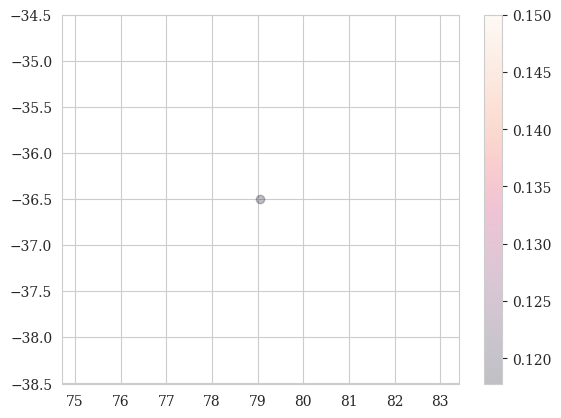

In [23]:
plt.scatter(res[:,2][MASK], res[:,1][MASK],c=cost[MASK], alpha=0.25, vmax=vmax)
plt.colorbar()

27.12005768414149


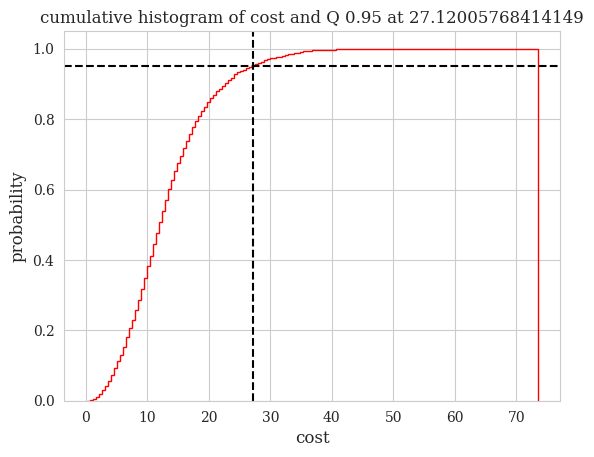

In [24]:
q = 0.95
plt.hist(cost,bins = 150, cumulative=True,histtype='step', density=True, stacked =True, color='r')
plt.axhline(y = q, color = 'k', linestyle = '--')
plt.axvline(x = np.quantile(cost, q=q), color = 'k', linestyle = '--')
plt.title("cumulative histogram of cost and Q {} at {}".format(q,np.quantile(cost,q=q)) )
plt.xlabel("cost")
plt.ylabel("probability")
print(np.quantile(cost,q=q))

# Association visualization

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed


files = glob2.glob(f"{DETECTIONS_DIR}/cache/associations.pkl")

def process_file(file):
    local_nb_per_coord = {n: {} for n in range(3, 15)}

    with open(file, "rb") as f:
        while True:
            try:
                association = pickle.load(f)
                detections, valid_points = association
                for i in valid_points:
                    local_nb_per_coord[len(detections)].setdefault(i, 0)
                    local_nb_per_coord[len(detections)][i] += 1
            except EOFError:
                break

    return local_nb_per_coord

nb_per_coord = {n: {i:0 for i in range(len(GRID_TO_COORDS))} for n in range(3, 15)}

with ProcessPoolExecutor(14) as executor:
    futures = [executor.submit(process_file, file) for file in files]

    for future in tqdm(as_completed(futures), total=len(files)):
        local_result = future.result()
        for n in local_result:
            for key, value in local_result[n].items():
                nb_per_coord[n][key] += value

with open(f"{DETECTIONS_DIR}/cache/nb_per_coord.pkl", "wb") as f:
    pickle.dump(nb_per_coord, f)

In [ ]:
local_nb_per_coord = {n: {i:0 for i in range(len(GRID_TO_COORDS))} for n in range(3, 15)}
for j in range(len(association)):
    if len(association[j]) != 2 :
        print(len(association[j]))
    detections, valid_points = association[j]
    for i in valid_points:
        local_nb_per_coord[len(detections)].setdefault(i, 0)
        local_nb_per_coord[len(detections)][i] += 1
nb_per_coord = local_nb_per_coord

In [ ]:
plt.rcParams.update({'font.size': 12})

min_size_display = 10
log = False
weights = np.array([np.sum([nb_per_coord[n][i] for n in range(min_size_display,15)]) for i in range(len(GRID_TO_COORDS))])

fig, ax = plt.subplots()
width_in = 6.8
height_in = width_in/1.11
fig.set_size_inches(width_in, height_in)
sq, _, _ = squarize(GRID_TO_COORDS, weights, LAT_BOUNDS, LON_BOUNDS, size=1400)
# if log:
#     sq[sq<1] = 1
#     sq = np.log10(sq)
#     sq[sq>3.5] = 3.5
#     sq[sq<2] = 2
# else:
#     sq[sq>2000] = 2000

im = ax.imshow(sq[::-1], cmap="inferno",extent=(LON_BOUNDS[0], LON_BOUNDS[-1], LAT_BOUNDS[0], LAT_BOUNDS[-1]), vmax=800)
xticks = np.arange(np.floor(LON_BOUNDS[0]/5)*5, np.ceil(LON_BOUNDS[-1]/5)*5 + 5, 5)
yticks = np.arange(np.floor(LAT_BOUNDS[0]/5)*5, np.ceil(LAT_BOUNDS[-1]/5)*5 + 5, 5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

for s_ in STATIONS:
    p = s_.get_pos()
    if p[0] > LAT_BOUNDS[1] or p[0] < LAT_BOUNDS[0] or p[1] > LON_BOUNDS[1] or p[1] < LON_BOUNDS[0]:
        print(f"Station {s_.name} out of bounds")
        continue
    ax.plot(p[1], p[0], 'yx', alpha=0.75, markersize=10, markeredgewidth=2)
    ax.annotate(s_.name, xy=(p[1], p[0]), xytext=(p[1]-(LON_BOUNDS[1]-LON_BOUNDS[0])/30, p[0]+(LAT_BOUNDS[1]-LAT_BOUNDS[0])/50), textcoords="data", color='y', alpha=0.9, weight='bold')
cbar = plt.colorbar(im,fraction=0.0415, pad=0.04)
cbar.set_label(f'Counts of resulting associations{" (log)" if log else ""}', rotation=270, labelpad=20)
ax.set_title(f"Resulting map")
ax.set_xlabel("lon (°)")
ax.set_ylabel("lat (°)")
Path(f"{DETECTIONS_DIR}/figures").mkdir(exist_ok=True)
plt.savefig(f'{DETECTIONS_DIR}/figures/map_min-{min_size_display}_{"log" if log else ""}.png', dpi=500, bbox_inches='tight')

In [ ]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

for s_ in STATIONS:
    p = s_.get_pos()
    # if p[0] > LAT_BOUNDS[1] or p[0] < LAT_BOUNDS[0] or p[1] > LON_BOUNDS[1] or p[1] < LON_BOUNDS[0]:
    #     print(f"Station {s_.name} out of bounds")
    #     continue
    ax.plot(p[1], p[0], 'yx', alpha=0.75, markersize=10, markeredgewidth=2)
    ax.annotate(s_.name, xy=(p[1], p[0]), xytext=(p[1]-(LON_BOUNDS[1]-LON_BOUNDS[0])/30, p[0]+(LAT_BOUNDS[1]-LAT_BOUNDS[0])/50), textcoords="data", color='y', alpha=0.9, weight='bold')


# COAST
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, color='black')
# GRIDS
ax.set_extent([np.min(lons)-1, np.max(lons)+1, np.min(lats)-1, np.max(lats)+1])
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([20, 60, 100, 140])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.scatter(GRID_TO_COORDS[:,1],GRID_TO_COORDS[:,0],c=weights, cmap="inferno",vmax=800)

cbar = plt.colorbar(im,fraction=0.0415, pad=0.04)
cbar.set_label(f'Counts of resulting associations{" (log)" if log else ""}', rotation=270, labelpad=20)
ax.set_title(f"Resulting map")
ax.set_xlabel("lon (°)")
ax.set_ylabel("lat (°)")
Path(f"{DETECTIONS_DIR}/figures").mkdir(exist_ok=True)
plt.savefig(f'{DETECTIONS_DIR}/figures/map_min-{min_size_display}_{"log" if log else ""}.png', dpi=500, bbox_inches='tight')
plt.colorbar()